In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from IPython.display import display

from sklearn.datasets import load_breast_cancer
import shap
#plt.style.use('default')

shap.initjs()

Используем датасет <code>cancer</code> и случайный лес. Обучимся и посмотрим результат.

Важная особенность! Для простоты дальнейшей работы с библиотекой `SHAP` признаки `X` должны быть в виде `pd.DataFrame` с именами столбцов.

## 3. Варианты визуализации результатов применения векторов Шепли

Визуализацию можно разделить на следущие группы:
1. Глобальный - визуализация значимости всех признаков в среднем для всего набора данных.
2. Локальная -  визуализация значимости признаков для конкретного результата
3. Попарная визуализация зависисмость признаков

Еще раз все повторим, обучим модель, упакуем резудьтат расчета для модели векторов Шепли и посмотрим на графики.

Упаковка результата уменьшает код в описательной части графиков.

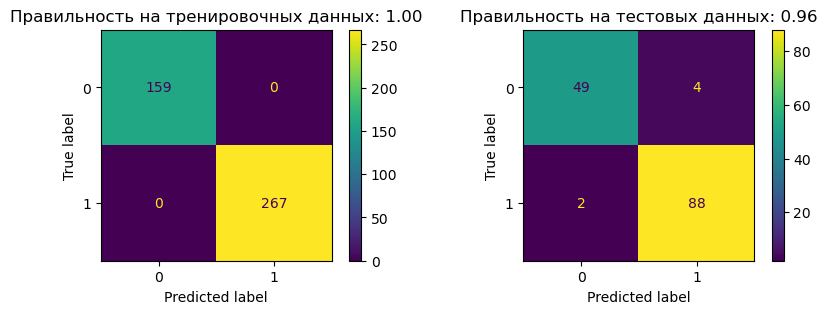

In [2]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns = data.feature_names)
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify=y)
forest = RandomForestClassifier(n_estimators = 500, random_state = 42)
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)
y_train_pred = forest.predict(X_train)
y_pred_proba = forest.predict_proba(X_test)



fig, ax = plt.subplots(1,2, figsize=(10,3))
ConfusionMatrixDisplay.from_estimator(forest, X_train, y_train, ax = ax[0]);
ax[0].set_title( "Правильность на тренировочных данных: {:.2f}".format(forest.score(X_train, y_train)) )
ConfusionMatrixDisplay.from_estimator(forest, X_test, y_test, ax = ax[1]);
ax[1].set_title( "Правильность на тестовых данных: {:.2f}".format(forest.score(X_test, y_test)) );

In [3]:
feature_names = data.feature_names

explainer = shap.explainers.Tree(forest, X_train)

# упаковка тренировочного набора
method_train = explainer(X_train)
explanation_train = shap.Explanation(values = method_train.values[:,:,1], 
                  base_values =  method_train.base_values[:,1], 
                  data = X_train.values, 
                  feature_names = feature_names)

# упаковка тестового набора
method_test = explainer(X_test)
explanation_test = shap.Explanation(values = method_test.values[:,:,1], 
                  base_values =  method_test.base_values[:,1], 
                  data = X_test.values, 
                  feature_names = feature_names
                  )

### 3.1 Глобальный анализ значимости

Выполняется на тренировочном или полном наборе данных, для выделения наиболее важных признаков в данных

#### 3.1.1  `summary_plot` и `beeswarm`

Очень похожие графики, один строит зависимость для всех признаков, другой для указанного числа и остальных. 

Каждая горизонтальная линия соответствует одному признаку feature_names, и на этой линии отмечаются точки, соответствующие тестовым примерам: кордината точки на линии соответствует значению вектора Шепли shap_values , цвет точки - значению признака features. Если в каком-то участке линии не хватает места для всех точек, линия начинает расти в ширину. Таким образом, для каждого признака схема представляет собой слившееся множество точек, по одной точке для каждого примера.

Значение Feature value на графике слева показывает в нашем случае близость значения полученного вектора к искомому классу. В нашем случае синий это класc 0, красный класс 1.

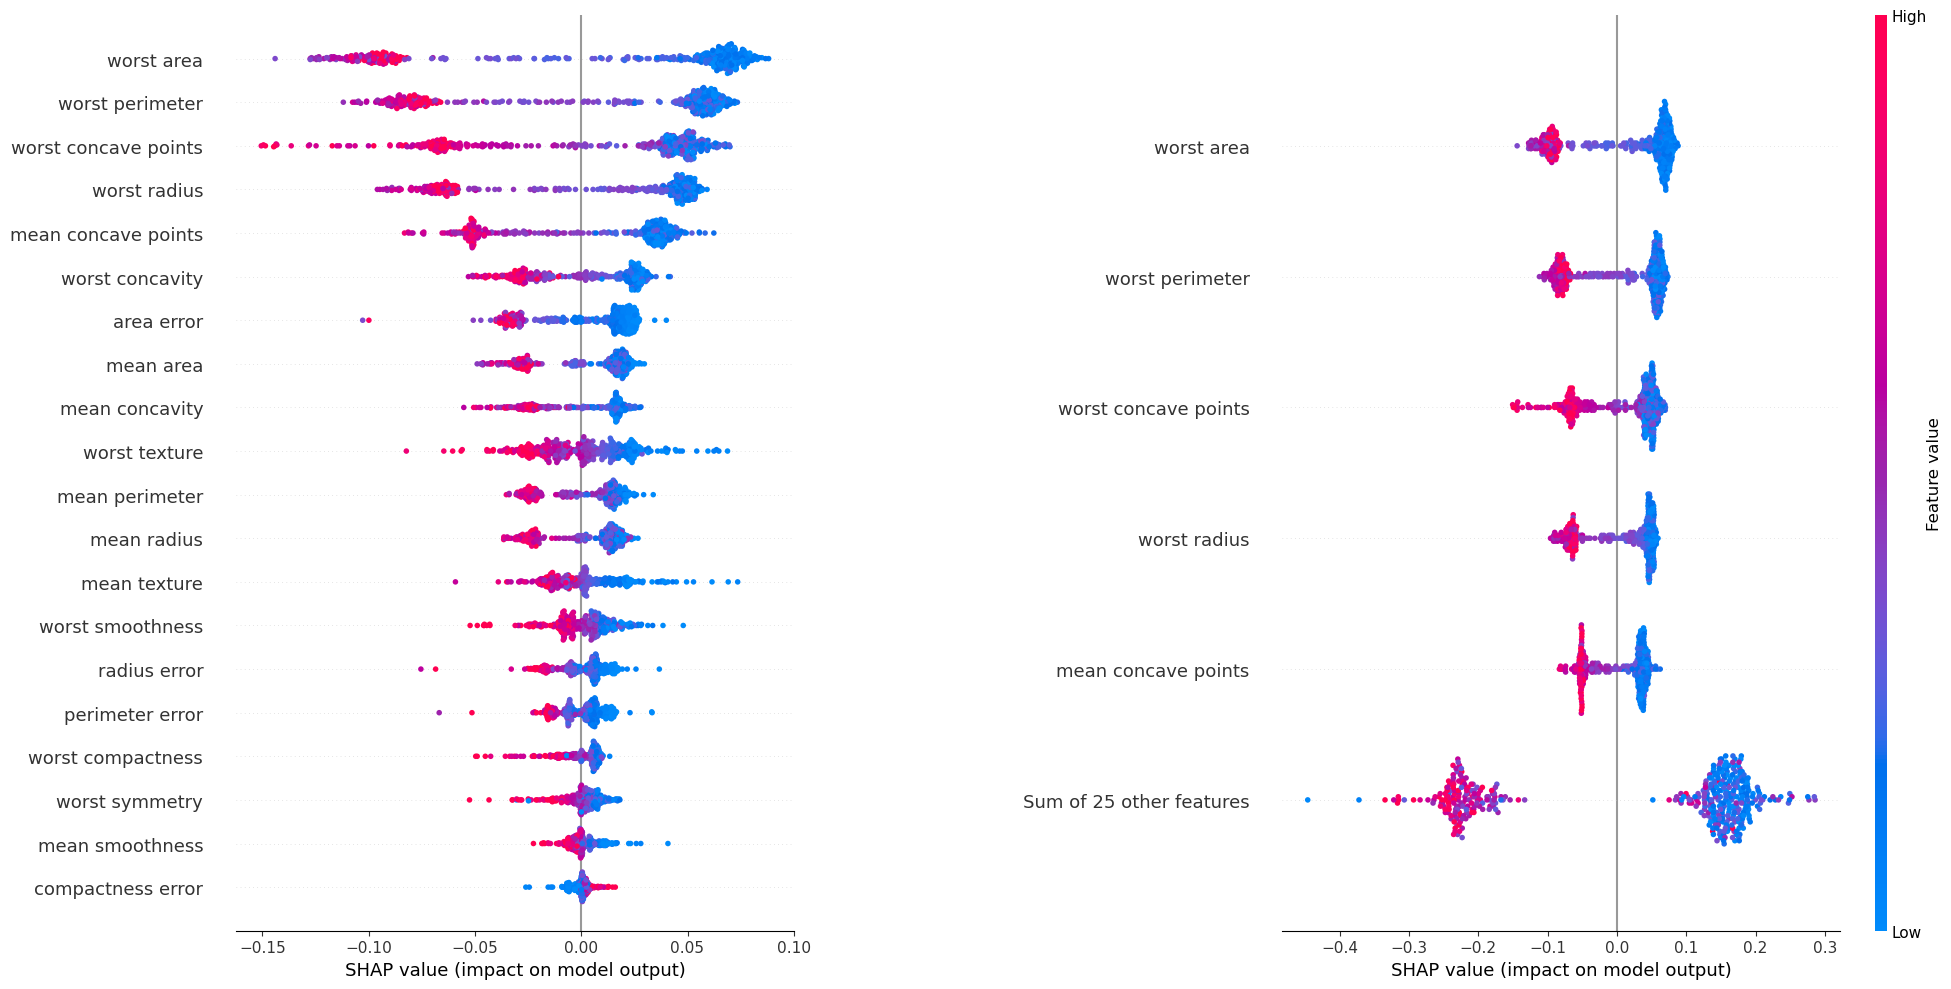

In [4]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
shap.summary_plot(explanation_train, 
                  plot_size=None, show=False) # это нужно только для отрисовки графиков рядом в subplot
plt.subplot(1,2,2)
shap.plots.beeswarm(explanation_train, max_display=6,plot_size=None, show=False)
plt.subplots_adjust(wspace = 0.5)# это нужно только для разрыва в графиках

#### 3.1.2  Глобальный bat plot

Строится график глобальной важности признаков, где глобальная важность каждого признака принимается за среднее (можно изменить) абсолютное значение для этого признака по всем заданным выборкам.

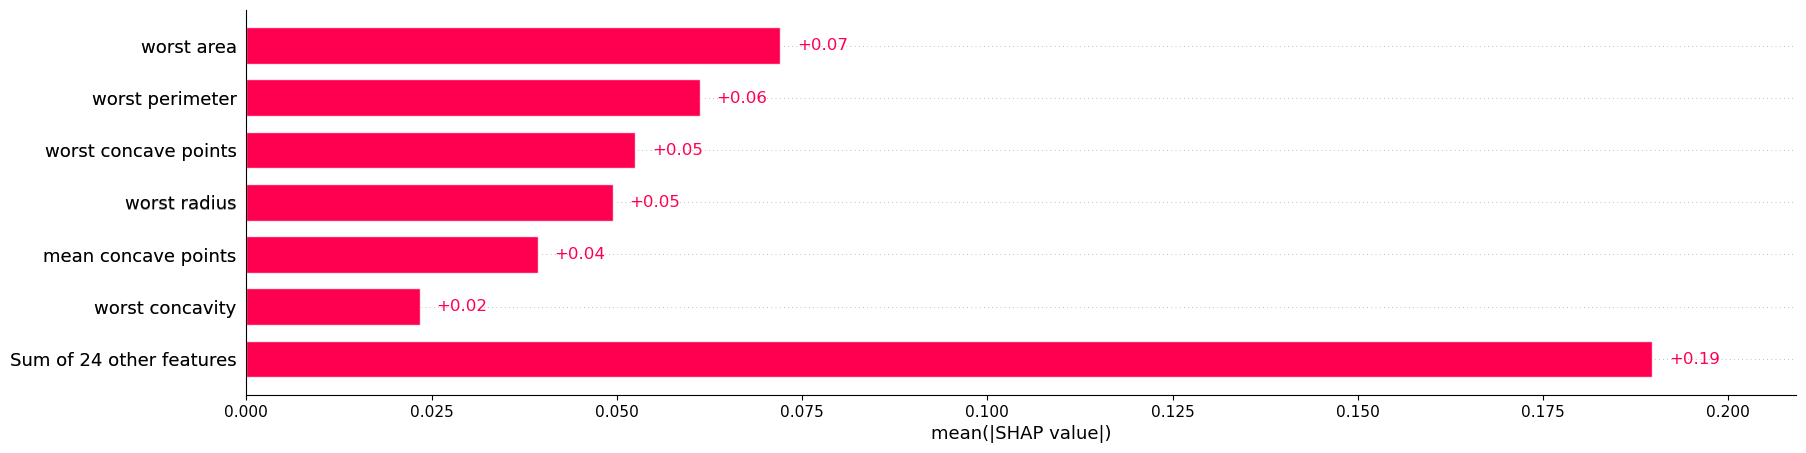

In [35]:
shap.plots.bar(explanation_train, max_display = 7, show = False)
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(4*h, h)
plt.show()

Кстати, существует возможность разделить бары по категориальной переменной, например по полу. 
Если мы использовали деревья решений, то `cohorts(N)` сколько ветвей дерева дерева повлило на разделение важности признаков.

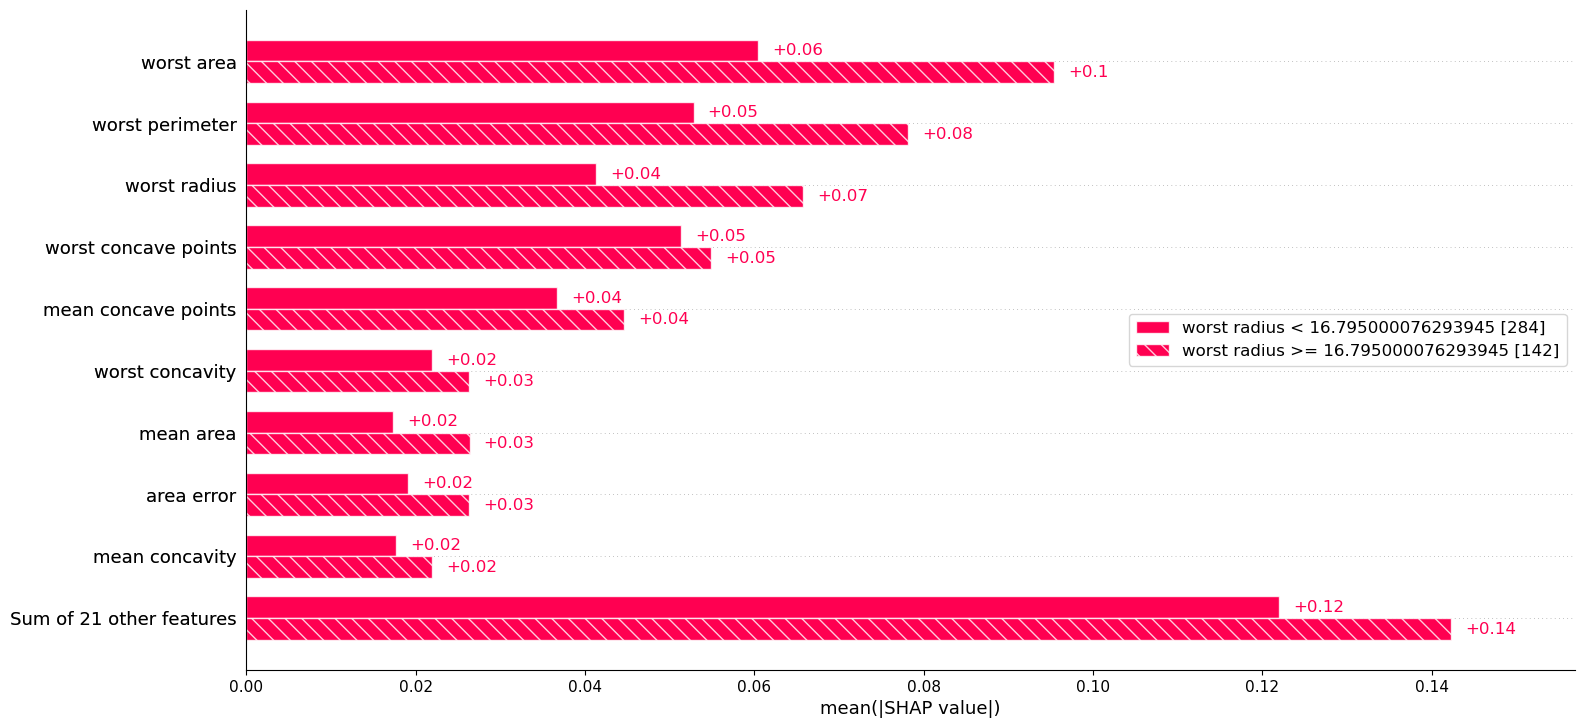

In [41]:
shap.plots.bar(explanation_train.cohorts(2).abs.mean(0), show = False)
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(2*h, h)
plt.show()

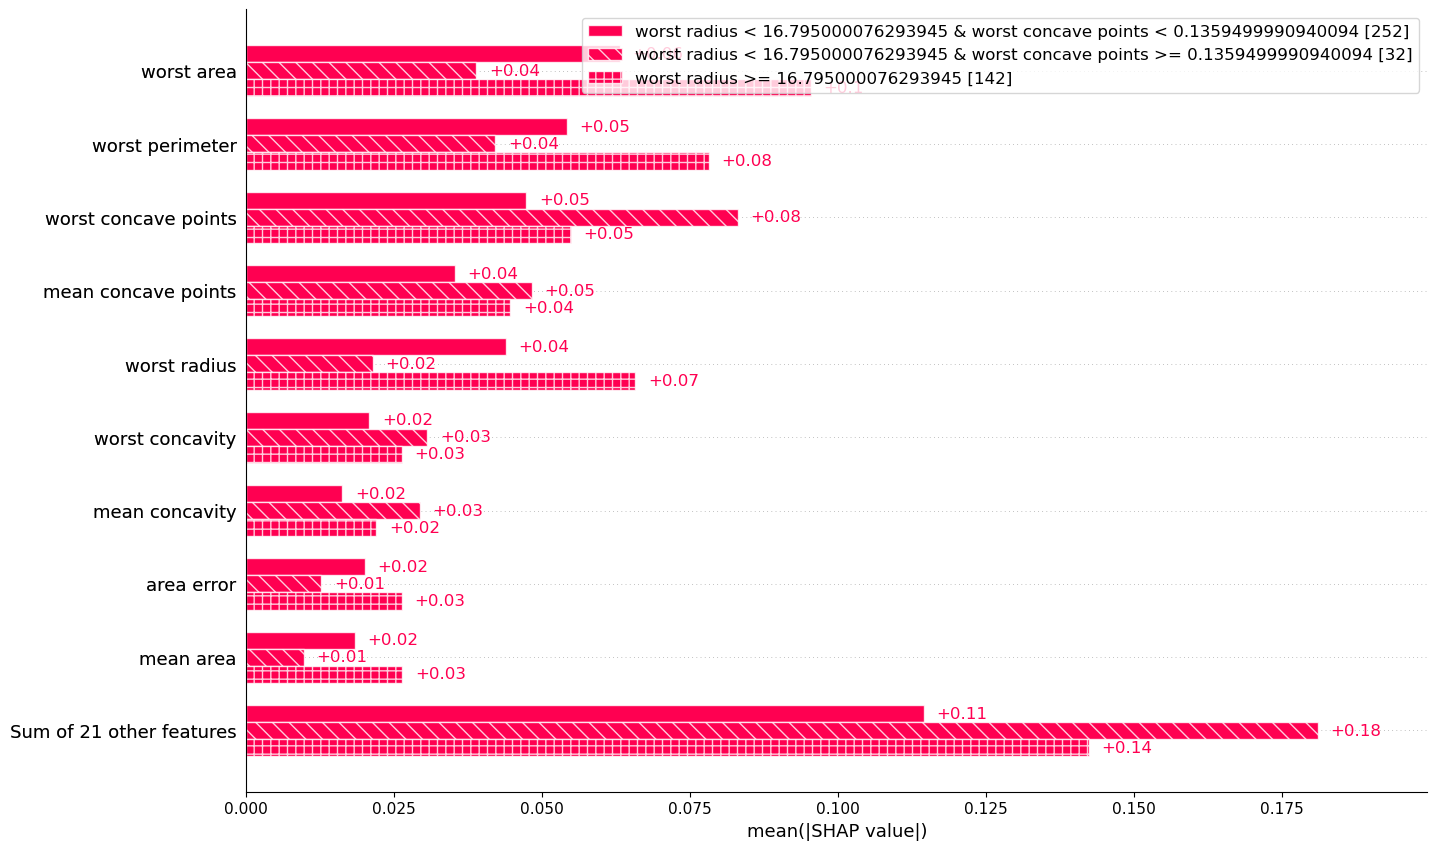

In [49]:
shap.plots.bar(explanation_train.cohorts(3).abs.mean(0), show = False)
_, h = plt.gcf().get_size_inches()
plt.gcf().set_size_inches(1.5*h, h)
plt.show()

#### 3.1.3  Тепловая карта `heatmap`

Позволяет построить график, разместив на оси $x$ значения результата решения модели по каждой строке данных (в нашем случае какой класс предсказан для каждой строки данных), признаками (названиями столбцов данных) модели на оси $y$ и значениями SHAP, закодированными в цветовой шкале. 

 **Важно!** По умолчанию строки упорядочиваются с помощью sharp.order.hclust, который упорядочивает строки данных на основе иерархической кластеризации по сходству их объяснений. Это приводит к тому, что строки, имеющие одинаковые выходные данные модели по одной и той же причине, группируются вместе (например, люди с онкологией).

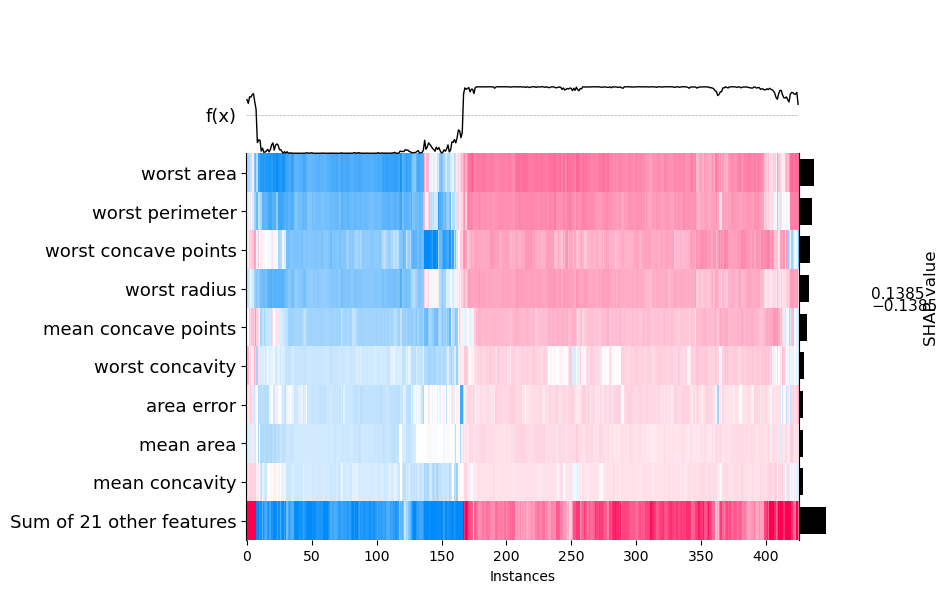

In [61]:
shap.plots.heatmap(explanation_train,plot_width = 8)
# _, h = plt.gcf().get_size_inches()
# plt.gcf().set_size_inches(2*h, h)
# plt.show()

Давайте проверим тестовый и тренировочный набор и посмотрим, где возникли ошибки.

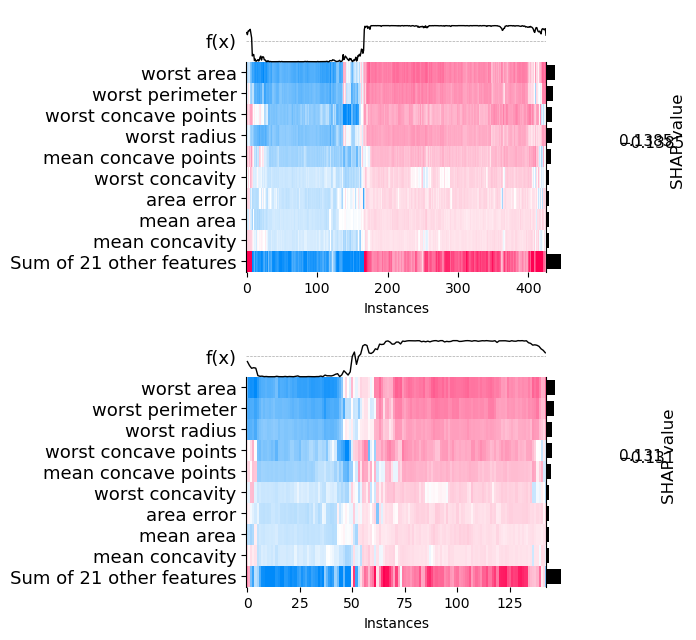

In [62]:
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
shap.plots.heatmap(explanation_train, show=False)
plt.subplot(2,1,2)
shap.plots.heatmap(explanation_test, show=False)


Посмотрите на результат кластеризации есть 3 очевидные зоны риска:
1. В начале нет 1, все 0
2. В середине - не плавный переход.
3. В конце - завал графика

`hclust()` позволит посмотреть нам индексы строк разбившихся в иерахрическую кластеризацию.

In [10]:
err = explanation_test.hclust()[:10]
print('истинные      :', y_test[err])
print('предсказанные :', y_pred[err])

истинные      : [1 0 1 0 0 0 0 0 0 0]
предсказанные : [0 0 0 0 0 0 0 0 0 0]


In [11]:
err = explanation_test.hclust()[50:70]
print('истинные      :', y_test[err])
print('предсказанные :', y_pred[err])

истинные      : [1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]
предсказанные : [1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [12]:
err = explanation_test.hclust()[125:]
print('истинные      :', y_test[err])
print('предсказанные :', y_pred[err])

истинные      : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0]
предсказанные : [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Мы выявили все шесть проблемных значения.

Возможно, что среди признаков есть шумы, и их нужно убрать. Мы уже ранее так делали. А затем посмотреть как изменится качество обучения. Оставим это для самостоятельной работы.

Иногда полезно посмотреть на данные другим углом, например вычислив сумму  значений векторов Шепли и отсорировах их по данному значению. Это позволит посмотреть значимость признаков при переходных значениях из класса 0 в класс 1.

Обычно, если переход отвестный, то нам удалось качественно разделить классы, но если на тестовой выборке картинка не столь "хороша", то возможно мы переобучились на тренировочном наборе. При анализе, не забывайте учитывать разное количество данных на оси $x$, это влияет на визуальное сравнение двух графиков.

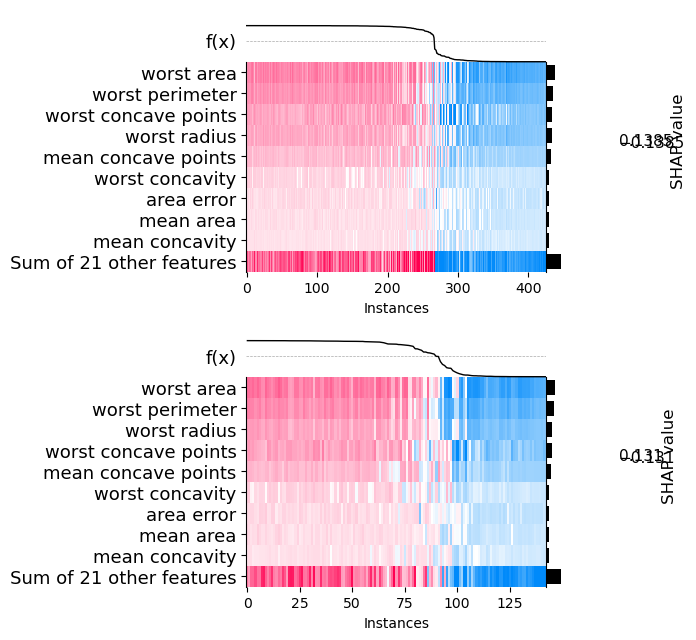

In [13]:
plt.figure(figsize=(10,15))
plt.subplot(2,1,1)
shap.plots.heatmap(explanation_train, instance_order=explanation_train.sum(axis=1), show=False)
plt.subplot(2,1,2)
shap.plots.heatmap(explanation_test,  instance_order=explanation_test.sum(axis=1),  show=False)


### 3.2 Локальный анализ значимости

Выполняется обычно на тестовом наборе данных, для объяснения полученного результата

#### 3.1.1  `force` и `waterfall`

В нашем случае каждый класс предсказан с вероятностью рассчитаной с `predict_proba`. График  `force_plot` и `waterfall_plot` позволяет посмотреть, какие признаки и как сильно повлияли на это. 

В данном случае для начальной точки построения находим базовое значение прогноза, а затем смотрим какие признаки сдвигают конкретный прогноз относительно базового вправо или влево.

In [14]:
# найдем строуки с расхождением предсказанного и истинного значения
np.argwhere(y_test!=y_pred)

array([[  4],
       [ 44],
       [ 62],
       [ 92],
       [118],
       [135]])

In [65]:
# зафиксируем номер прогноза
i = 4
print ('истинный класс:            ',y_test[i])
print ('предсказанный класс класс: ',y_pred[i])

shap.force_plot( explanation_test[i])


истинный класс:             0
предсказанный класс класс:  1


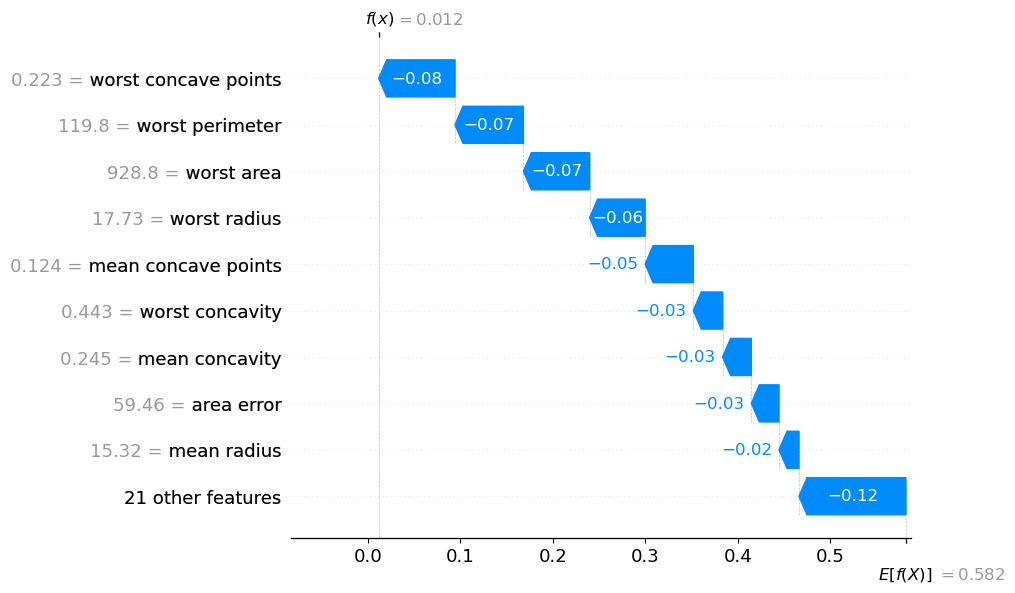

In [16]:
shap.plots.waterfall(explanation_test[i], max_display=10)

## 3.3. Попарная визуализация зависисмость признаков
### 3.3.1. График `scatter`  

График показывает влияние одного признака на прогнозы, сделанные моделью.

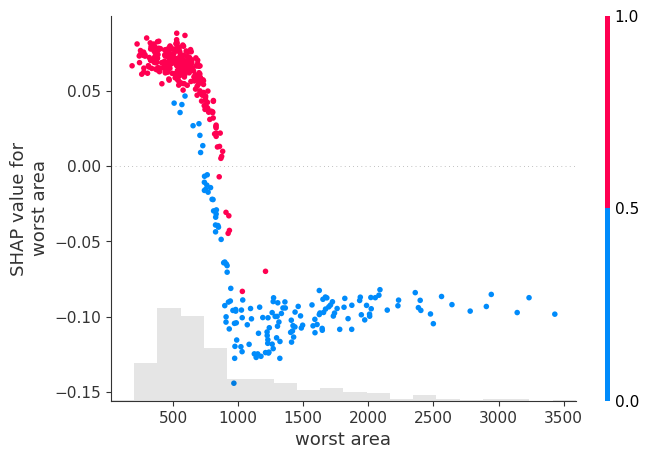

In [17]:
shap.plots.scatter(explanation_train[:,"worst area"], color=y_train)

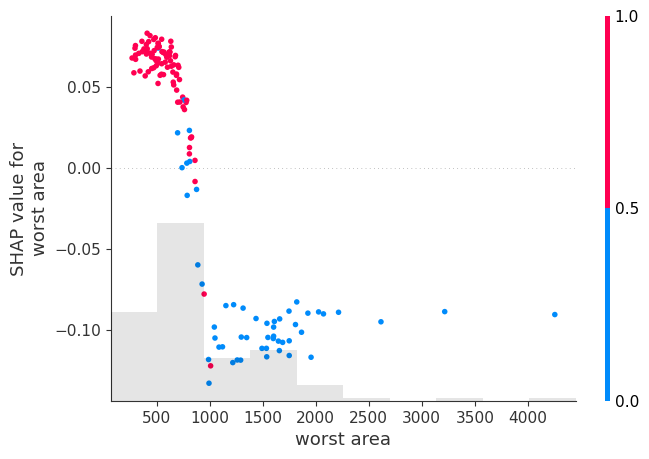

In [18]:
shap.plots.scatter(explanation_test[:,"worst area"], color=y_test)

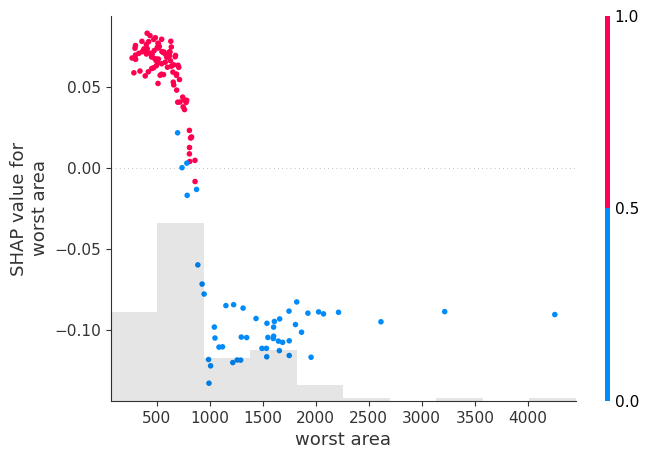

In [19]:
shap.plots.scatter(explanation_test[:,"worst area"], color=y_pred)

Построение графика для третьего по значимости параметра

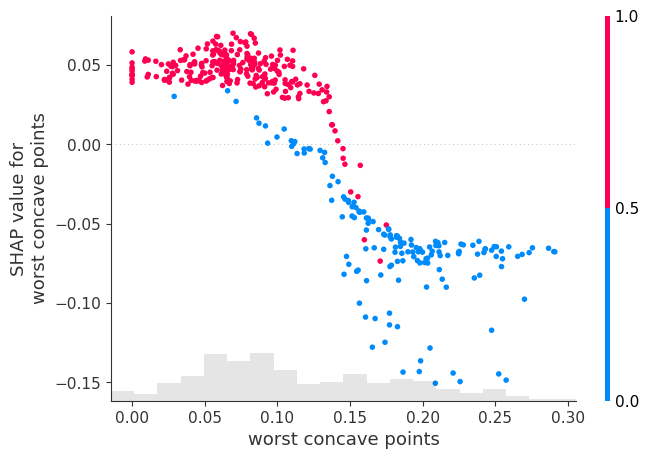

In [20]:
shap.plots.scatter(explanation_train[:, explanation_train.abs.mean(0).argsort[-3]], color=y_train)

### 3.3.2. График `dependence_plot`

Данный график позволяет выявить попарные закономерности между значением признака (ось $X$), его вектором Шепли (ось $Y$) и значение второго признака (цветом).

Цвет соответствующий второму признаку, который может иметь некоторый эффект взаимодействия с первым признаком (по умолчанию второй признак выбирается автоматически с самым большим эффектом взаимодействия). 

Данный пример не очень удачен для выявления таких закономерностей, но часто бывает, что их можно визуально определить, особенно в регрессионых задачах.

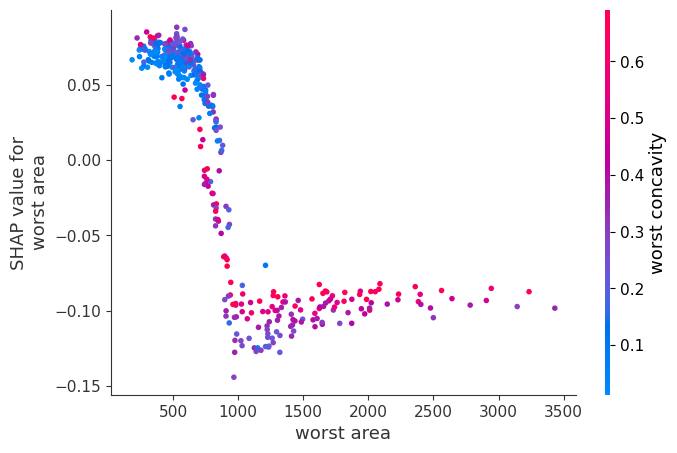

In [21]:
shap.dependence_plot('worst area', explanation_train.values, X_train)

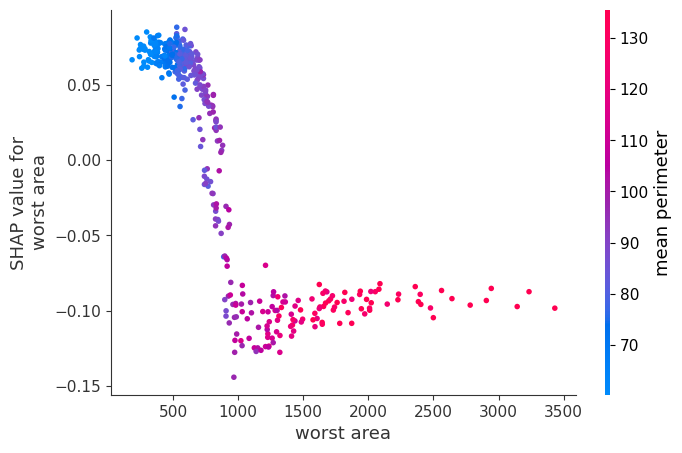

In [22]:
shap.dependence_plot('worst area', explanation_train.values, X_train, interaction_index='mean perimeter')

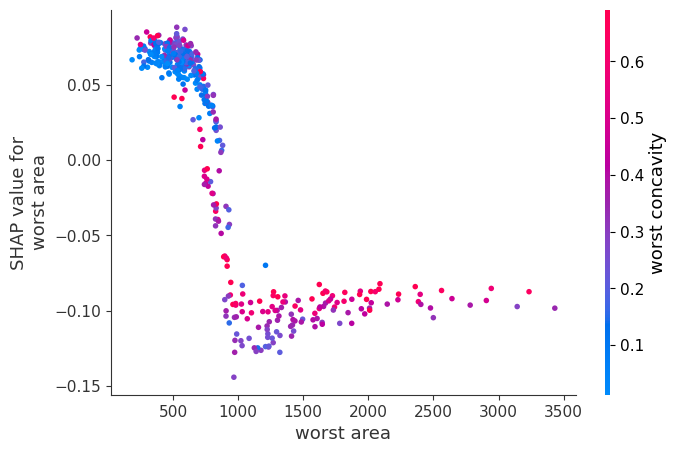

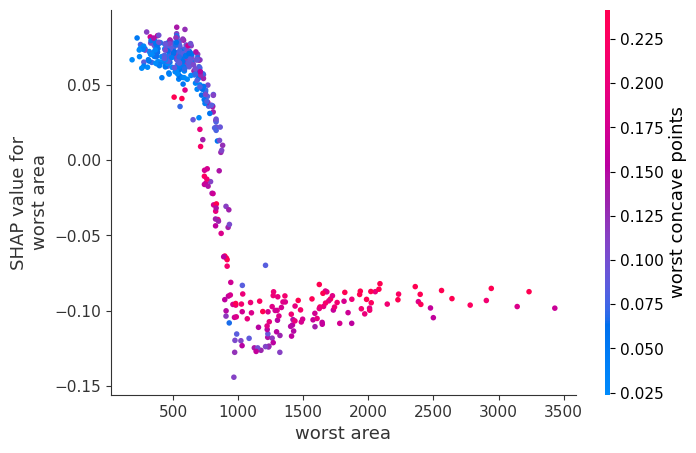

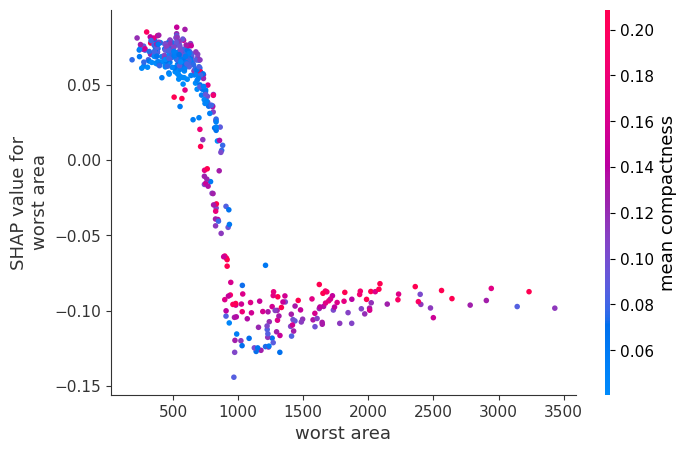

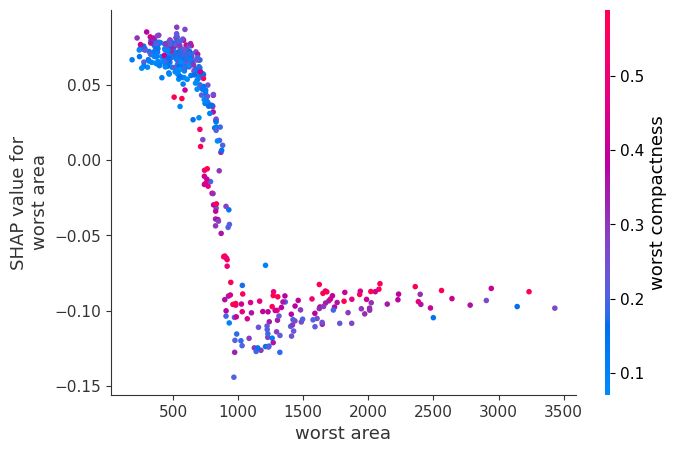

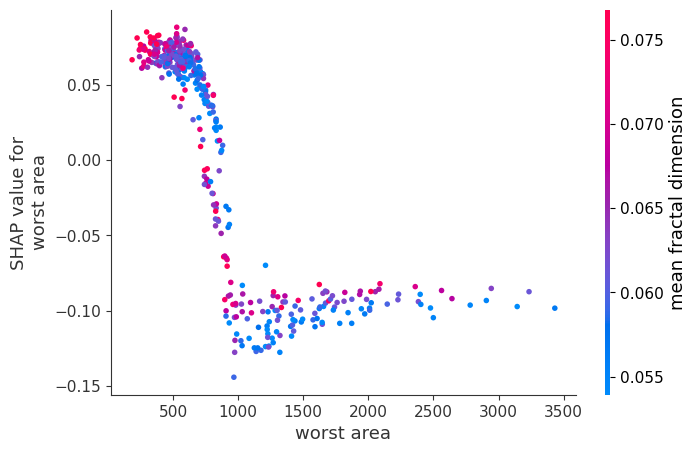

In [23]:
# используем shap.approximate_interactions для того чтобы найти
# какие признаки сильнее всего взаимодействуют с "worst area"
inds = shap.approximate_interactions("worst area", explanation_train.values, X_train)

# окрасим графики для 5 наиболее сильно взаимодействующих признаков с зафиксированным нами признаком "worst area"
for i in range(5):
    shap.dependence_plot("worst area", explanation_train.values, X_train, interaction_index=inds[i])

### 3.3.2. График `force`  

Если мы возьмем графика `force`  для каждой сточки данных, как ранее показывали, повернем их на 90 градусов, а затем составляем по вместе по горизонтали, то мы можем увидеть интерпритацию для всего набора данных на интерактивном графике.</br>
Можно менять попарные значения на осях $x$ и $y$.

In [24]:
shap.plots.force(explanation_train)